# Configuración

## Librerías y funciones

In [21]:
import tensorflow as tf
from keras.metrics import Precision, Recall
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Resizing, RandomZoom, RandomHeight, RandomWidth
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Definiciones del dataset

In [2]:
data_dir = 'data_model'
resolution=(256, 455)
num_classes=len(os.listdir(data_dir))

## Configuración del GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-05-31 20:59:50.017043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 20:59:50.027907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 20:59:50.027937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Carga y procesamiento de datos

In [5]:
data = tf.keras.utils.image_dataset_from_directory(directory=data_dir,
                                                   label_mode='categorical',
                                                   image_size=resolution)

Found 9213 files belonging to 72 classes.


2023-05-31 20:59:50.553664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 20:59:50.553713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 20:59:50.553726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 20:59:51.033722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 20:59:51.033763: I tensorflow/compile

### Escalamiento

In [6]:
data = data.map(lambda x,y:(x/255, y))

### Split

In [7]:
train_size=int(len(data)*0.7)+1
dev_size=int(len(data)*0.15)
test_size=int(len(data)*0.15)

In [8]:
if train_size+dev_size+test_size==len(data):
    print('Split correcto')
else:
    print('Split incorrecto')

Split correcto


In [9]:
train = data.take(train_size)
dev = data.skip(train_size).take(dev_size)
test = data.skip(train_size+dev_size).map(lambda x,y: (tf.image.resize(x, size=(224, 224)), y)).take(test_size)

# Modelo

### Aumento de datos

In [10]:
data_augment=Sequential([
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2)
])

In [11]:
example_folder=os.listdir(data_dir)[np.random.randint(0,num_classes)]
example_file=os.path.join(data_dir, example_folder, os.listdir(os.path.join(data_dir, example_folder))[np.random.randint(len(os.listdir(os.path.join(data_dir, example_folder))))])
example_file

'data_model/Scope_opening/10_14_3_878_34.png'

(341, 426, 3)

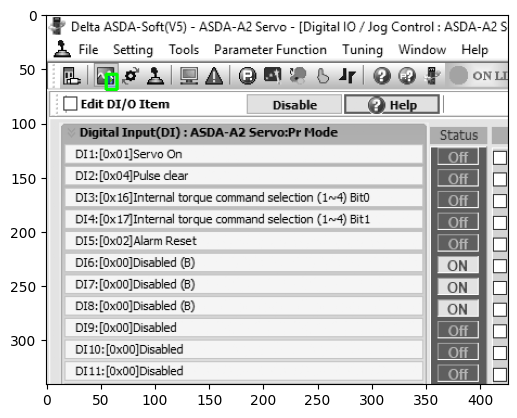

In [12]:
example=plt.imread(example_file)
plt.imshow(example)
example.shape

TensorShape([1, 311, 394, 3])

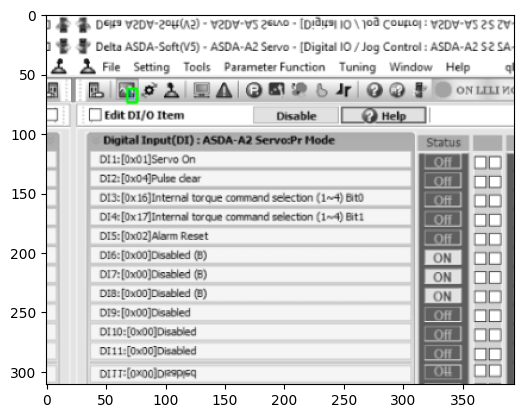

In [13]:
out=data_augment(np.expand_dims(example, axis=0))
plt.imshow(np.squeeze(out))
out.shape

### Búsqueda de hiperparámetros

In [14]:
def model_builder(hp):

    inputs=Input(shape=resolution+(3,))
    x=data_augment(inputs, training=True)
    x=Resizing(224, 224)(x)

    hp_ks=hp.Int('kernel_size', min_value=3, max_value=7, step=2)
    hp_activation=hp.Choice('activation', values=['relu', 'leaky_relu', 'elu'])
    hp_lambda=hp.Choice('l2', values=[0.01, 0.001, 0.0001])
    hp_prob=hp.Choice('rate', values=[0.01, 0.1, 0.2])
    hp_layers=hp.Int('num_layers', min_value=1, max_value=5, step=1)
    hp_filters=hp.Int('num_filters', min_value=16, max_value=128, step=30)
    hp_units=hp.Int('units', min_value=300, max_value=500, step=100)
    hp_lr=hp.Choice('learning_rate', values=[1e-2, 1e-3])
    n=2

    x=Conv2D(hp_filters, hp_ks, 1, padding='same', activation=hp_activation, kernel_regularizer=L2(hp_lambda))(x)
    x=MaxPooling2D()(x)
    x=Dropout(hp_prob)(x)

    for _ in range(hp_layers):
        x=Conv2D(n*hp_filters, hp_ks, 1, padding='same', activation=hp_activation, kernel_regularizer=L2(hp_lambda))(x)
        x=MaxPooling2D()(x)
        x=Dropout(hp_prob)(x)
        n*=2

    x=Flatten()(x)

    x=Dense(hp_units, activation=hp_activation)(x)
    x=Dropout(hp_prob)(x)

    outputs=Dense(num_classes, activation='softmax')(x)

    model=Model(inputs, outputs)

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=hp_lr))

    return model

In [15]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='Augmented_model',
                     project_name='model_search_3')

In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [26]:
# Reducir la tasa de aprendizaje tras 10 épocas para un ajuste más fino
def scheduler(epoch, lr):
    if epoch<=10:
        return lr
    else:
        return lr*np.exp(-0.9)

lr_scheduler=LearningRateScheduler(scheduler)

In [17]:
tuner.search(train, epochs=50, callbacks=[stop_early], validation_data=dev)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best kernel size: {best_hps.get('kernel_size')}")
print(f"Best number of units: {best_hps.get('units')}")
print(f"Best activation function: {best_hps.get('activation')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best lambda: {best_hps.get('l2')}")
print(f"Best rate: {best_hps.get('rate')}")
print(f"Best num of block: {best_hps.get('num_layers')}")
print(f"Best number of filters: {best_hps.get('num_filters')}")

Trial 27 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.8931686282157898
Total elapsed time: 01h 00m 08s
Best kernel size: 3
Best number of units: 400
Best activation function: leaky_relu
Best learning rate: 0.001
Best lambda: 0.0001
Best rate: 0.01
Best num of block: 1
Best number of filters: 16


### Modelo final

In [18]:
def final_model(ks, units, activation, lr, lmbda, prob):
    inputs=Input(shape=resolution+(3,))
    x=data_augment(inputs, training=True)
    x=Resizing(224, 224)(x)

    x=Conv2D(16, ks, 1, padding='same', activation=activation, kernel_regularizer=L2(lmbda))(x)
    x=MaxPooling2D()(x)
    x=Dropout(prob)(x)

    x=Conv2D(32, ks, 1, padding='same', activation=activation, kernel_regularizer=L2(lmbda))(x)
    x=MaxPooling2D()(x)
    x=Dropout(prob)(x)

    x=Conv2D(64, ks, 1, padding='same', activation=activation, kernel_regularizer=L2(lmbda))(x)
    x=MaxPooling2D()(x)
    x=Dropout(prob)(x)

    x=Conv2D(128, ks, 1, padding='same', activation=activation, kernel_regularizer=L2(lmbda))(x)
    x=MaxPooling2D()(x)
    x=Dropout(prob)(x)

    x=Flatten()(x)

    x=Dense(units, activation=activation)(x)

    outputs=Dense(num_classes, activation='softmax')(x)
    x=Dropout(prob)(x)

    model=Model(inputs, outputs)

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))

    return model

In [37]:
model=final_model(3, 512, 'leaky_relu', 0.001, 0.0001, 0.01)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing_8 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 112, 112, 16)      0         
                                                           

In [38]:
history=model.fit(train, epochs=100, validation_data=dev, callbacks=[stop_early, lr_scheduler])

Epoch 1/100


2023-05-31 22:15:34.438063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/202 [==============================] - 11s 53ms/step - loss: 2.0796 - accuracy: 0.4616 - val_loss: 0.9897 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - 11s 53ms/step - loss: 0.7955 - accuracy: 0.7574 - val_loss: 0.6266 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - 11s 54ms/step - loss: 0.5179 - accuracy: 0.8342 - val_loss: 0.4693 - val_accuracy: 0.8554 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - 11s 55ms/step - loss: 0.3998 - accuracy: 0.8711 - val_loss: 0.4870 - val_accuracy: 0.8605 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - 11s 54ms/step - loss: 0.3553 - accuracy: 0.8877 - val_loss: 0.4210 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - 11s 53ms/step - loss: 0.3095 - accuracy: 0.9025 - val_loss: 0.3708 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 7/100
202/202 [==============================] - 11s 54ms/

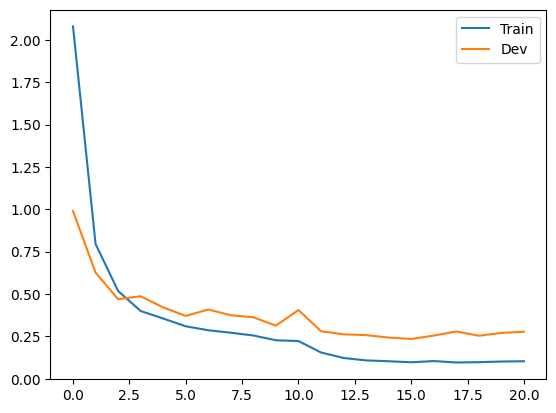

In [39]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Dev')
plt.legend();

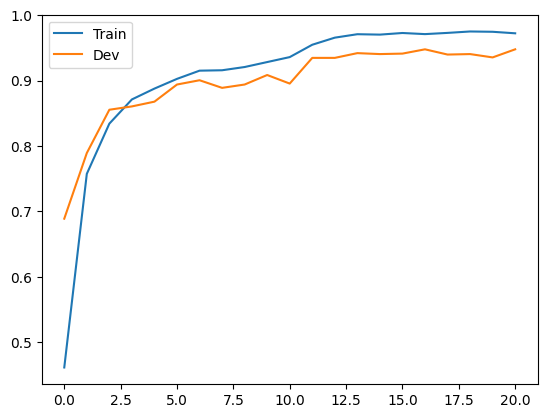

In [40]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Dev')
plt.legend();

# Evaluación

In [41]:
final_model=Sequential()

final_model.add(Input(shape=(224,224,3)))
for layer in model.layers[3:]:
    final_model.add(layer)

final_model.summary()
final_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 112, 112, 16)      0         
                                                                 
 conv2d_33 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 56, 56, 32)        0

In [42]:
pre=Precision()
re=Recall()

In [43]:
test

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 72), dtype=tf.float32, name=None))>

In [44]:
final_model.evaluate(test)

2023-05-31 22:20:29.401975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [9213]
	 [[{{node Placeholder/_0}}]]
2023-05-31 22:20:29.402156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [9213]
	 [[{{node Placeholder/_0}}]]


43/43 [==============================] - 3s 19ms/step - loss: 0.2491 - accuracy: 0.9541


[0.24908502399921417, 0.954115092754364]

In [45]:
for batch in test.as_numpy_iterator():
    x,y=batch
    yhat=final_model.predict(x, verbose=0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)

print(f'Recall: {re.result()}')
print(f'Precision: {pre.result()}')
print(f'F1 score: {(2*re.result()*pre.result())/(re.result()+pre.result())}')

Recall: 0.9533867239952087
Precision: 0.9582723379135132
F1 score: 0.9558233618736267


In [46]:
labels=os.listdir(data_dir)

In [47]:
yhat=np.array([])
ytrue=np.array([])

for x,y in test.as_numpy_iterator():
    yhat = np.concatenate([yhat, np.argmax(final_model.predict(x, verbose=0), axis = -1)])
    ytrue = np.concatenate([ytrue, np.argmax(y, axis=-1)])

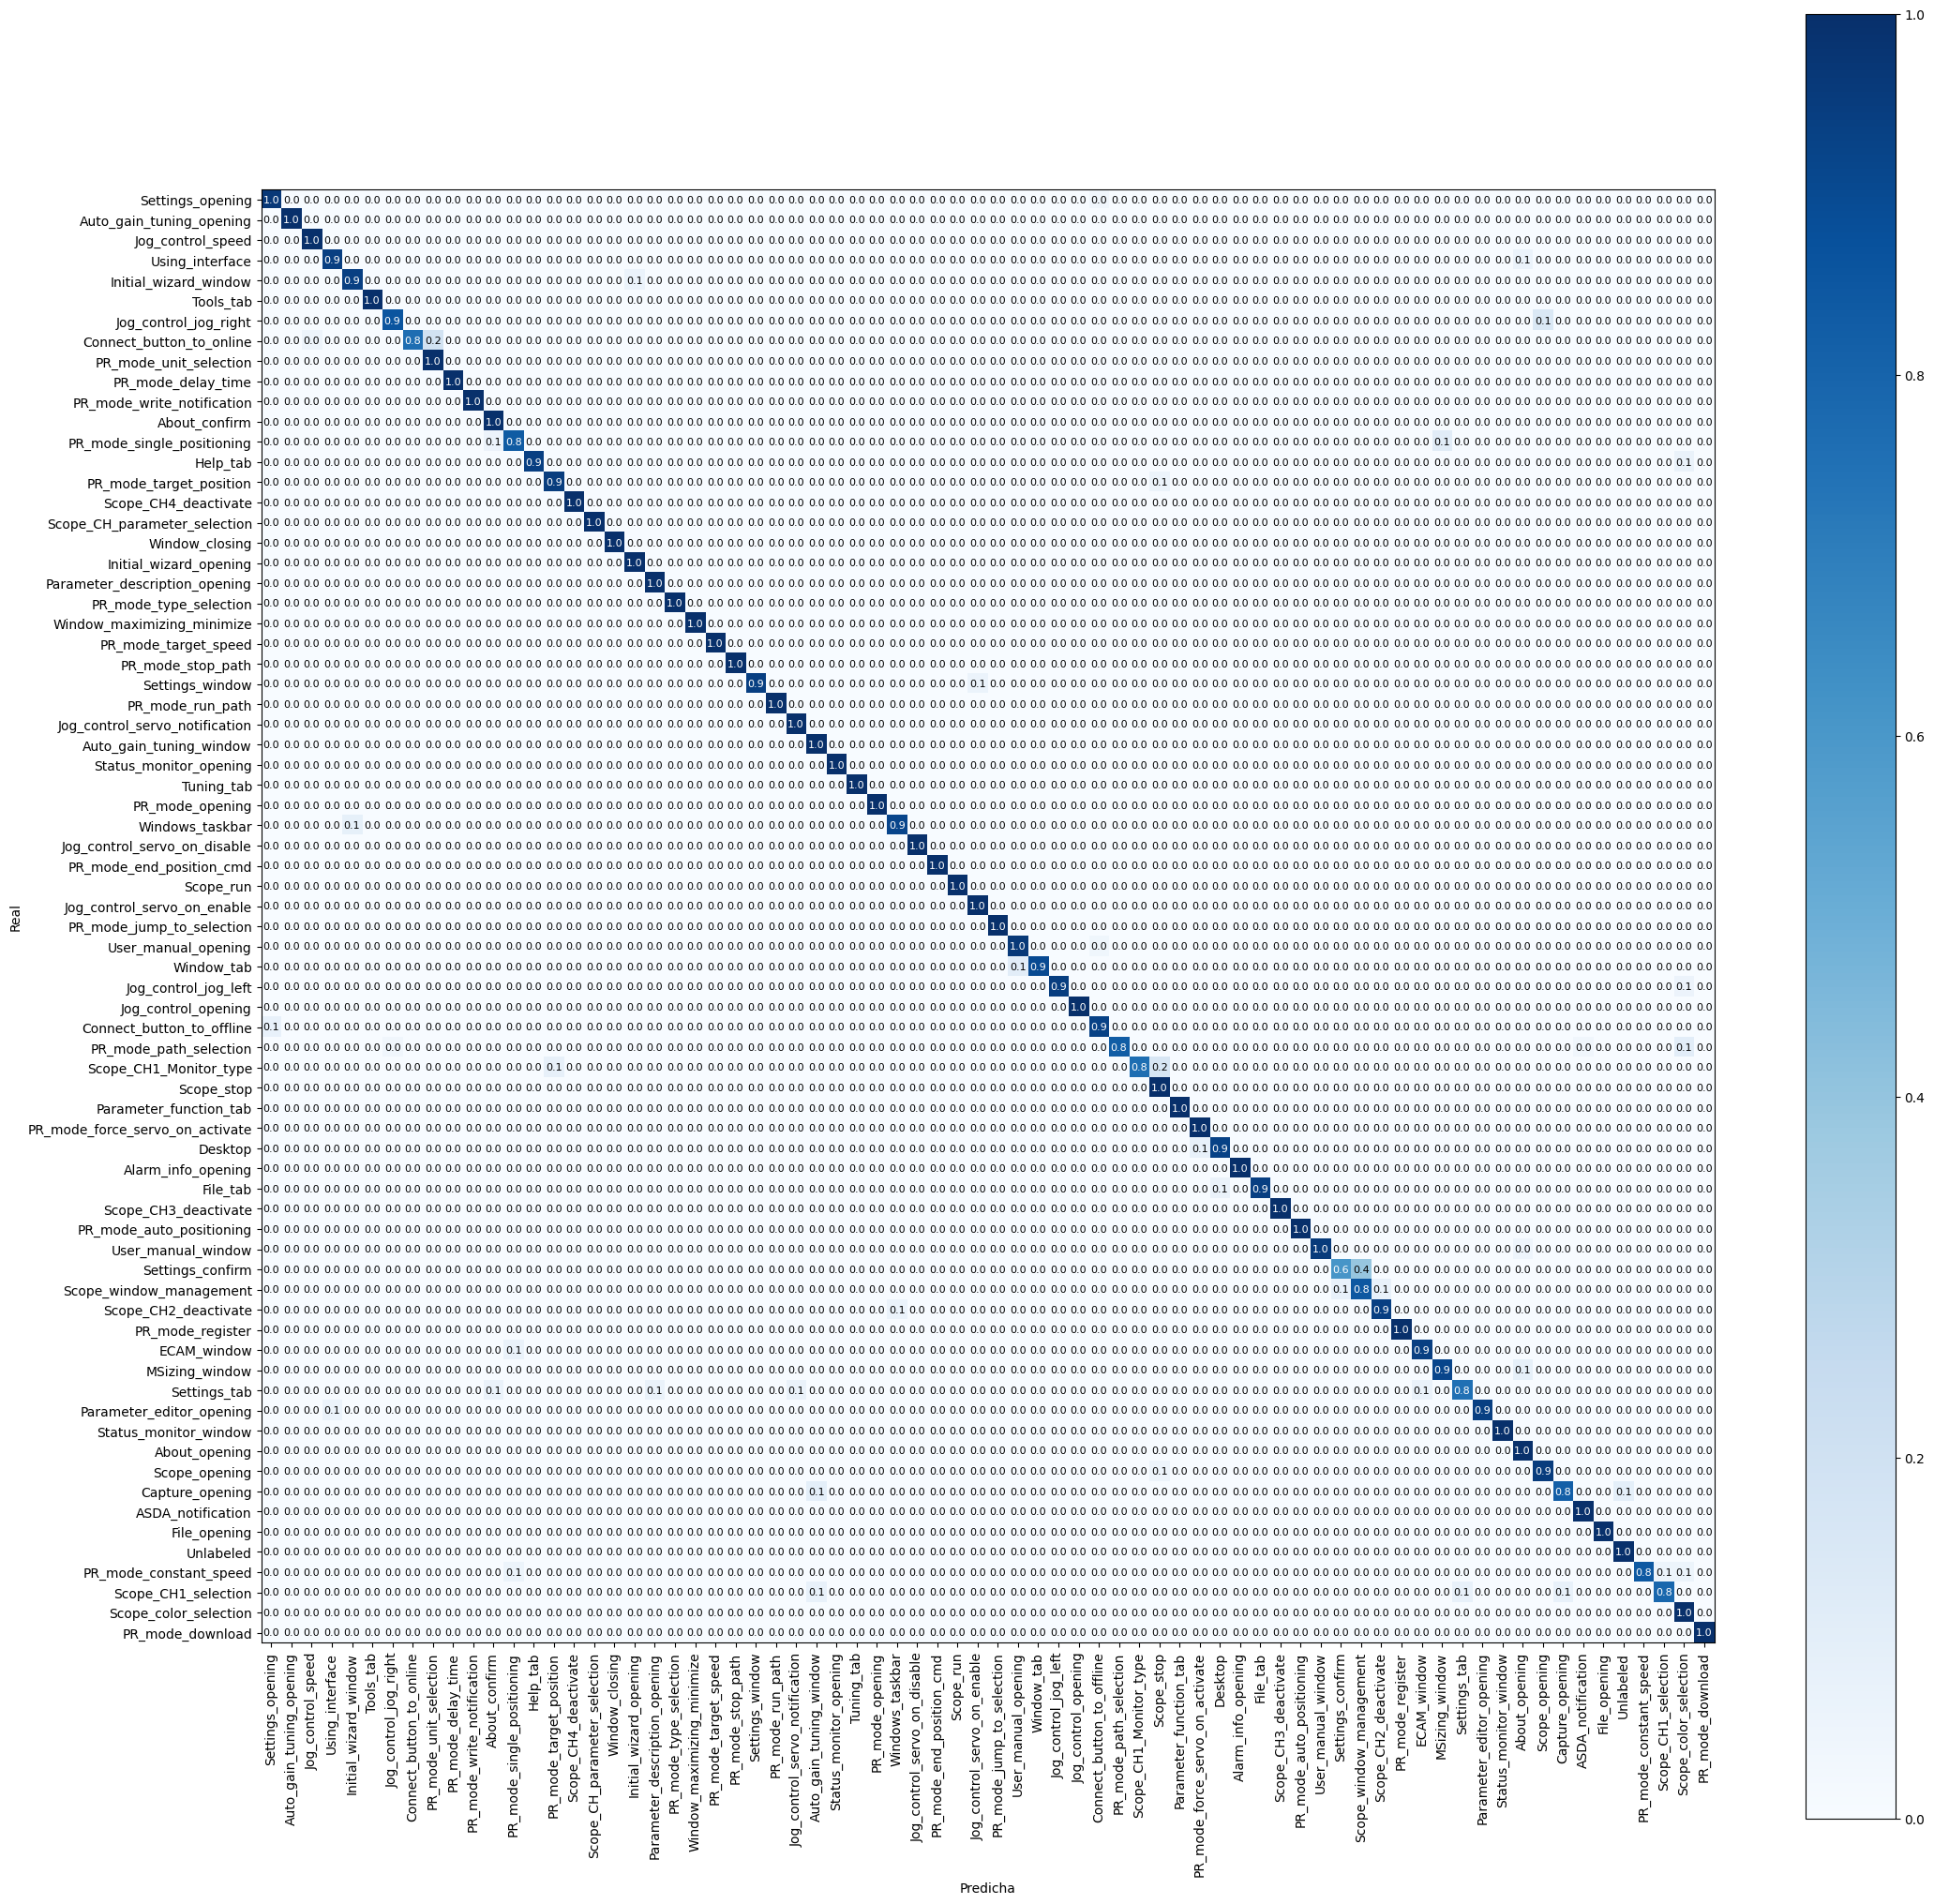

In [48]:
cm = confusion_matrix(ytrue, yhat)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels,
       yticklabels=labels,
       xlabel='Predicha',
       ylabel='Real')

thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j, i, format(cm_normalized[i, j], '.1f'),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black",
                fontsize=8)

        
plt.xticks(rotation='vertical')

fig.set_figheight(25)
fig.set_figwidth(25)
plt.show()

# Guardado del modelo

In [ ]:
final_model.save(os.path.join('models', 'clasificador_augmented.h5'))